<a href="https://colab.research.google.com/github/Pk22012003/SalesForecaster/blob/main/bigmartxg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

*Data* Collection and Processing

In [ ]:
# loading the data from csv file to Pandas DataFrame
big_mart_data = pd.read_csv('/content/Train.csv')

In [ ]:
# first 5 rows of the dataframe
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
# number of data points & number of features
big_mart_data.shape

(8523, 12)

In [ ]:
# getting some information about thye dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB






Categorical Features:
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [ ]:
# checking for missing values
big_mart_data.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


Handling Missing Values

Mean --> average

Mode --> more repeated value

In [ ]:
# mean value of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

np.float64(12.857645184135976)

In [ ]:
# Fill missing Item_Weight with mean
big_mart_data['Item_Weight'] = big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean())

In [ ]:
big_mart_data['Outlet_Size'].mode()

,Outlet_Size
0,Medium


In [ ]:
# Fill missing Outlet_Size with mode based on Outlet_Type
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type',
                                                aggfunc=lambda x: x.mode()[0])

In [ ]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [ ]:
miss_values = big_mart_data['Outlet_Size'].isnull()

In [ ]:
print(miss_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [ ]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values, 'Outlet_Type'].apply(
    lambda x: mode_of_Outlet_size[x])


In [ ]:
# checking for missing values
big_mart_data.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


Data Analysis

In [ ]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Numerical Features

In [ ]:
sns.set()

<ipython-input-18-21151ade0b57>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Weight'])


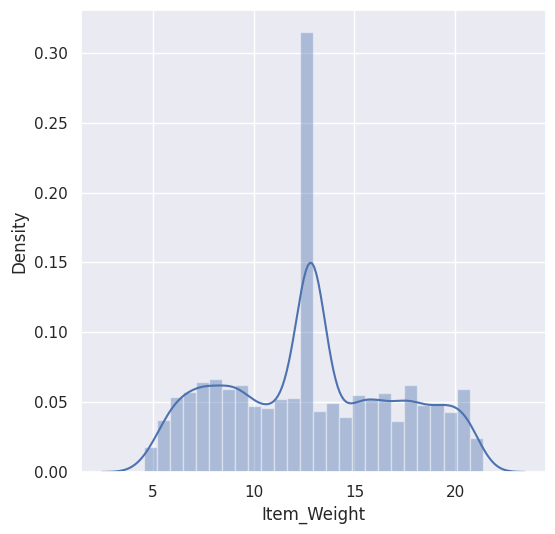

In [ ]:
# Item_Weight distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Weight'])
plt.show()

<ipython-input-19-386044597ca3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Visibility'])


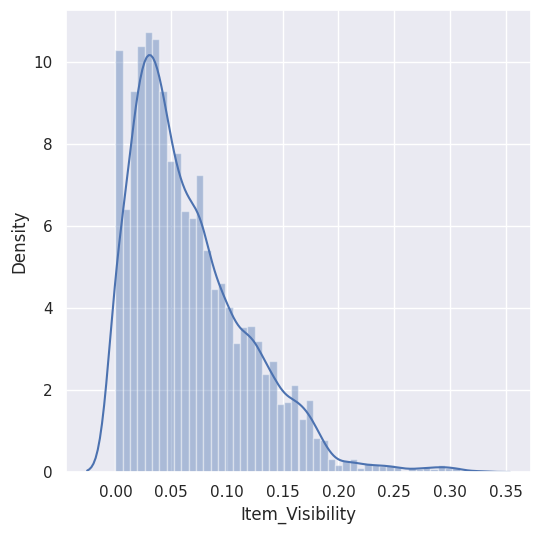

In [ ]:
# Item Visibility distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Visibility'])
plt.show()

<ipython-input-20-0b69bf4930c1>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_MRP'])


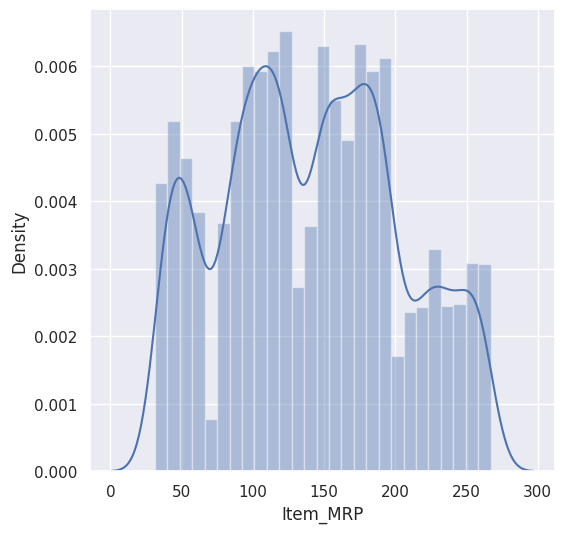

In [ ]:
# Item MRP distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_MRP'])
plt.show()

<ipython-input-21-dedd64409ff7>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Outlet_Sales'])


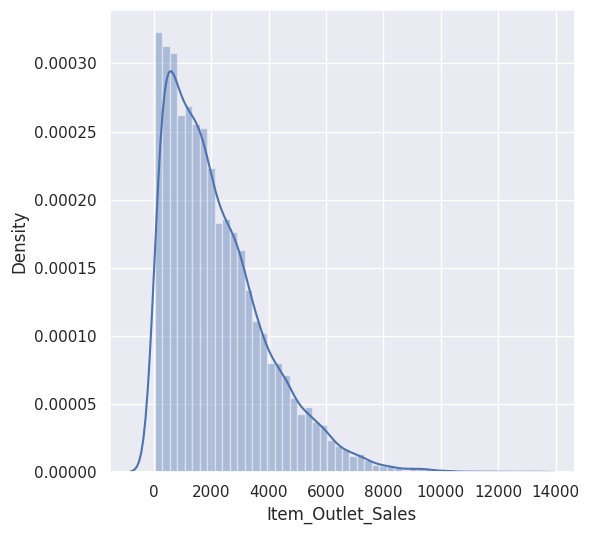

In [ ]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

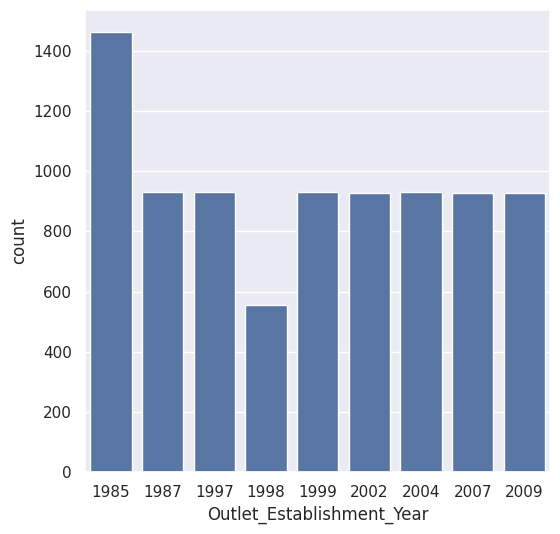

In [ ]:
# Outlet_Establishment_Year column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

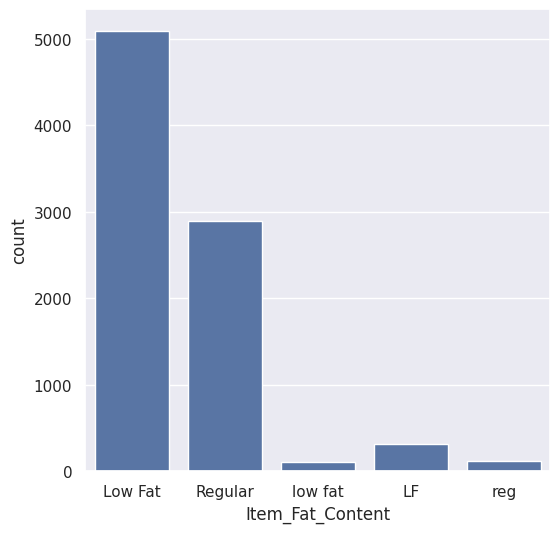

In [ ]:
# Item_Fat_Content column
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

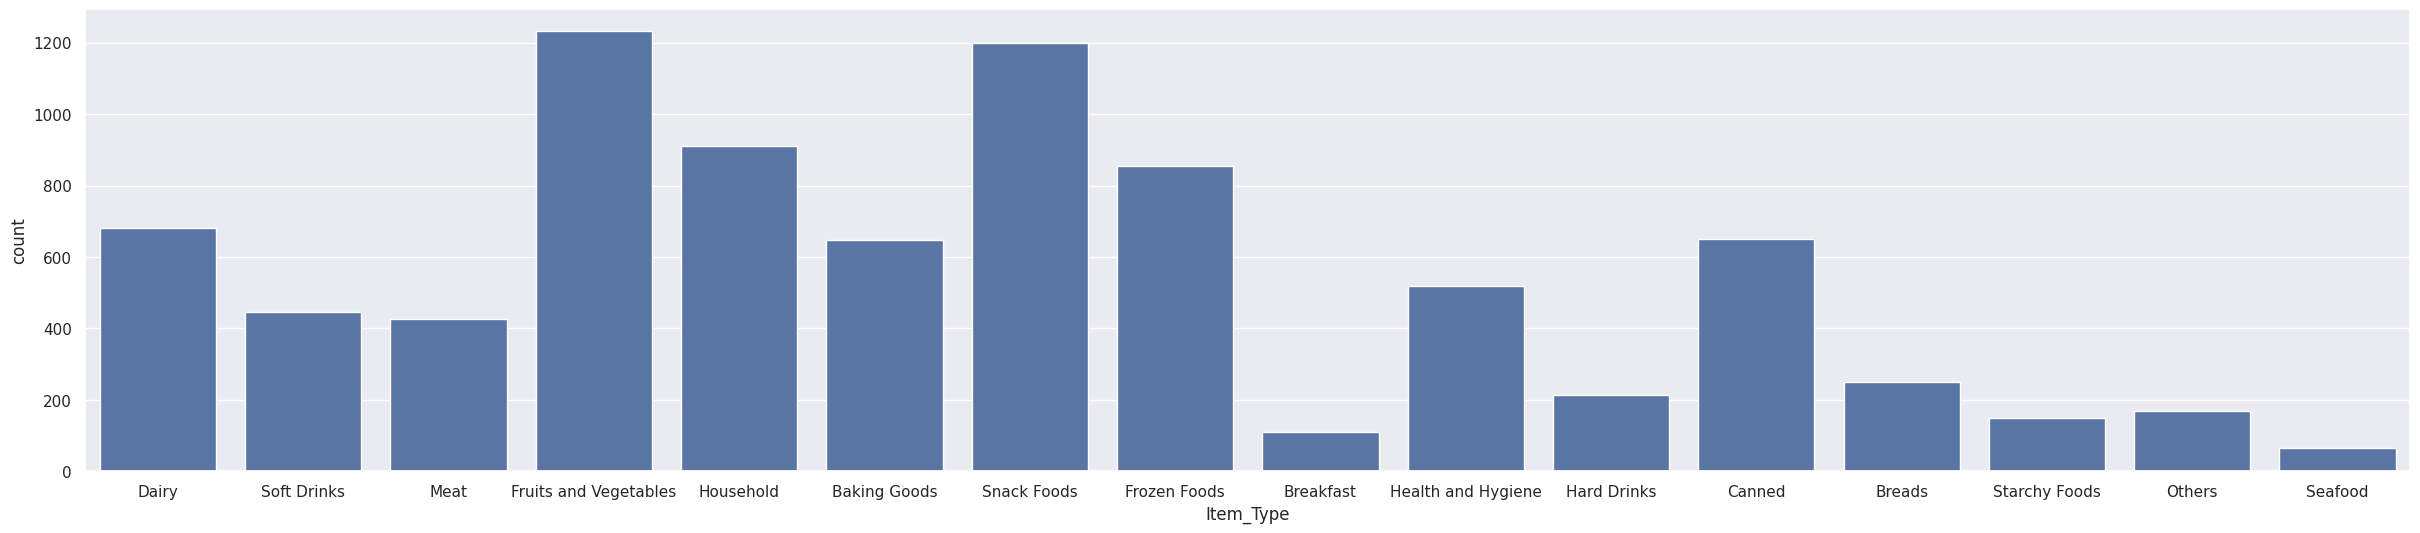

In [ ]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

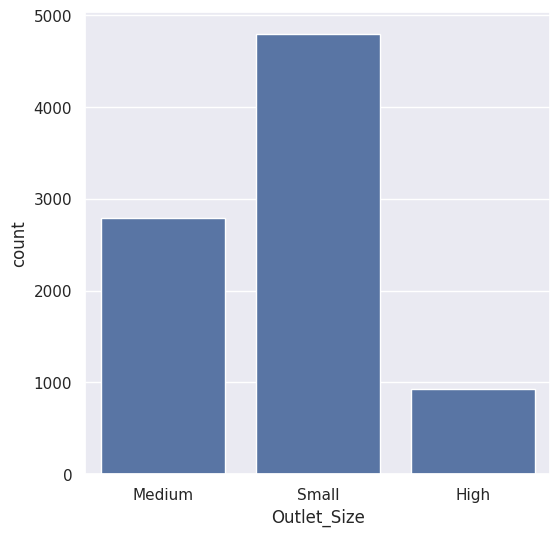

In [ ]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

*Data* Pre-Processing

In [ ]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
big_mart_data['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


In [ ]:
big_mart_data.replace({'Item_Fat_Content': {'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'}}, inplace=True)


In [ ]:
big_mart_data['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


Feature Engineering

In [ ]:
# Add Outlet Age
big_mart_data['Outlet_Age'] = 2025 - big_mart_data['Outlet_Establishment_Year']

In [ ]:
# Extract Item Category
big_mart_data['Item_Category'] = big_mart_data['Item_Identifier'].apply(lambda x: x[:2])

In [ ]:
# Create MRP Clusters
big_mart_data['MRP_Cluster'] = pd.cut(big_mart_data['Item_MRP'], bins=[0, 70, 140, 200, 300], labels=[1, 2, 3, 4])

In [ ]:
# Log Transform target
big_mart_data['Item_Outlet_Sales_Log'] = np.log1p(big_mart_data['Item_Outlet_Sales'])

In [ ]:
# Step 6: Log Transform Target
big_mart_data['Item_Outlet_Sales_Log'] = np.log1p(big_mart_data['Item_Outlet_Sales'])


*Label* Encoding

In [ ]:
le = LabelEncoder()

In [ ]:
cols_to_encode = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type',
                  'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
                  'Outlet_Type', 'Item_Category']

for col in cols_to_encode:
    big_mart_data[col] = le.fit_transform(big_mart_data[col])


In [ ]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Category,MRP_Cluster,Item_Outlet_Sales_Log
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380,26,1,4,8.225808
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228,16,0,1,6.096776
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700,26,1,3,7.648868
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800,27,1,3,6.597664
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052,38,2,1,6.903451


In [ ]:
#Encode MRP_Cluster
big_mart_data['MRP_Cluster'] = big_mart_data['MRP_Cluster'].astype(str)
big_mart_data['MRP_Cluster'] = le.fit_transform(big_mart_data['MRP_Cluster'])


Splitting features and Target

In [ ]:
X = big_mart_data.drop(columns=['Item_Outlet_Sales', 'Item_Outlet_Sales_Log'])
y = big_mart_data['Item_Outlet_Sales_Log']


In [ ]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [ ]:
print(y)

0       8.225808
1       6.096776
2       7.648868
3       6.597664
4       6.903451
          ...   
8518    7.929984
8519    6.310436
8520    7.085159
8521    7.521100
8522    6.642056
Name: Item_Outlet_Sales_Log, Length: 8523, dtype: float64


Splitting the data into Training data & Testing Data

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 14) (6818, 14) (1705, 14)


Machine Learning Model Training

XGBoost Regressor

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}


In [ ]:
xgb = XGBRegressor(random_state=42)


In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)


In [ ]:
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
# Best model
best_model = random_search.best_estimator_


Evaluation

In [ ]:
y_pred_log = best_model.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)          # Convert back to actual scale
y_test_actual = np.expm1(y_test)


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)


In [ ]:
print("Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Model Performance Metrics:
Mean Squared Error (MSE): 1117354.4263507924
Root Mean Squared Error (RMSE): 1057.0498693774066
Mean Absolute Error (MAE): 721.5912842174542
R2 Score: 0.5889011287965897
Mean Absolute Percentage Error (MAPE): 49.27335426459793


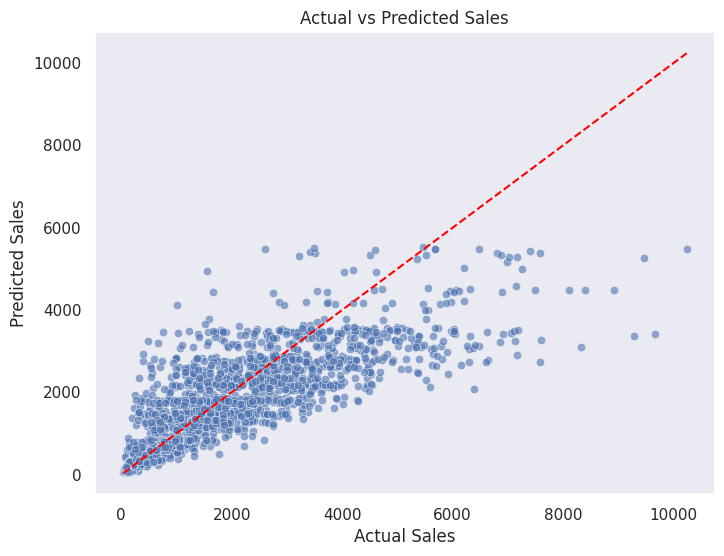

In [ ]:
# Step 14: Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         color='red', linestyle='--')
plt.grid()
plt.show()